# **D213 Performance Assessment 1:** Time Series Modeling

**Student:** Chris Fischer  
**ID:** 011933891  
**Dataset:** Telco Time Series  

# Part I: Study Overview
---

## A1: Research Question

Can BigTel's future daily revenue be forecasted accurately given 731 days of historical revenue data?

## A2: Objectives

This study hopes to develop a model for predicting future daily revenue using the two years of historical data provided. The study will attempt to produce a model and evaluate the accuracy of the forecast. This will be accomplished by reserving a portion of the provided data as a test set to be compared with the forecasted values for the same period. Lastly, the model will be used to forecast daily revenue for 60 days beyond the end of the historical dataset.

# Part II: Method Justification
---

## B: Assumptions

There are several assumptions which must be tested prior to developing an ARIMA model.
- **Stationarity**: ARIMA assumes that data is stationary, that is, the mean, variance, and autocorrelation do not change over time. Our study will examine the data for stationarity and transform it if required.
- **Univariate**: ARIMA can only model a single variable. Our study only includes revenue, and therefore conforms to this assumption.
- **Linearity**: The relationship between the dependent variable (revenue) and the independent variable (time) must be linear. In other words, future values must only depend on past values and past forecast errors rather than any abrupt external changes. For example, the COVID-19 pandemic was an external event which surely disrupted the linearity of many companies' revenue models. (Parth, 2023) and (Data Overload, 2023)

# Part III: Data Preparation
---

## C1: Time-series Visualization

#### Load the file

In [21]:
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load the csv file into a dataframe
df = pd.read_csv('telco_time_series.csv')
# Check data types and number of values, as well as overall size of dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB
None


#### Transform the Day column to a date

In [22]:
# Choose an arbitrary start date since none was provided in the scenario
start_date = pd.to_datetime('2019-12-31')

# Overwrite Day column with dates (Chugani, 2024)
df['Day'] = pd.to_timedelta(df['Day'], unit='D') + start_date 

# Replace the index
df.set_index('Day', inplace=True)
df.head(10)

,Revenue
Day,
2020-01-01,0.000000
2020-01-02,0.000793
2020-01-03,0.825542
2020-01-04,0.320332
2020-01-05,1.082554
2020-01-06,0.107654
2020-01-07,0.493901
2020-01-08,0.376698
2020-01-09,0.304075


In [23]:
df

,Revenue
Day,
2020-01-01,0.000000
2020-01-02,0.000793
2020-01-03,0.825542
2020-01-04,0.320332
2020-01-05,1.082554
...,...
2021-12-27,16.931559
2021-12-28,17.490666
2021-12-29,16.803638


#### Plot the data

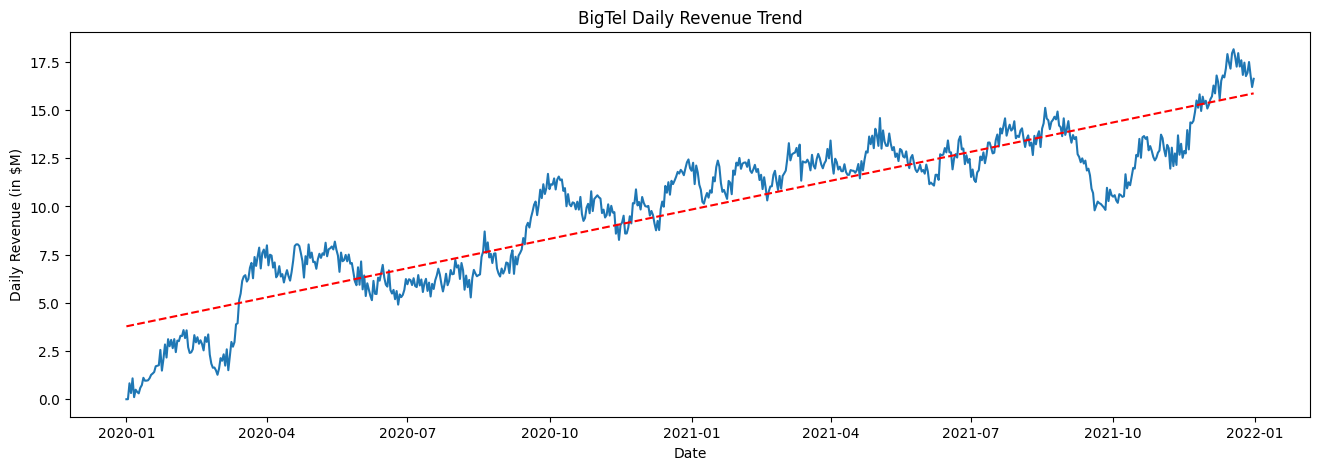

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

plt.figure(figsize = [16,5])
plt.title("BigTel Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Daily Revenue (in $M)")

# Plot time series data with trend line (Zach, 2020)
plt.plot(df)
x = mdates.date2num(df.index)
y = df['Revenue']
p = np.poly1d(np.polyfit(x, y, 1))
plt.plot(x, p(x), "r--")
plt.show()

## C2: Time-step Realization

The dataset provided contains 2 years of data with daily frequency. There are no gaps present in the dataset. As the file contains 731 values, it is assumed that the date range it represents includes a leap year. As no context of when this data occurred was provided in either the file or the given scenario, the analysts have arbitrarily assigned 01-Jan-2020 as the starting date. For the purposes of this forecasting study, the start date is not relevant, provided that those reading this report later understand that as the forecast ages, it will be less and less reflective of actual revenue.

## C3: Evaluate Stationarity

In [25]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df)

print('ADF TEST RESULTS')
print(f'\tADF Statistic: {result[0]:0.3f}')
print(f'\tADF p-value: {result[1]:0.3f}')

ADF TEST RESULTS
	ADF Statistic: -1.925
	ADF p-value: 0.321


The visualization show in __C1: Time-series Visualization__ clearly shows a positive trend. By itself, this intutitively demonstrates that the mean increases over time, therefore the data are not stationary. The Augmented Dickey Fuller (ADF) test result with a p-value > 0.05 confirms, statistically, what we intuited from the visualization. The data are not stationary and must be detrended prior to building an ARIMA model.

## C4: Data Preparation

Several data preparation steps are required prior to modeling. These are:
1. Convert the ordinal ___Day___ column to a date (performed in __Transform the Day column to a date__ above)
1. Remove any duplicate rows
1. Fill any missing data
1. Transform ___Revenue___ into a stationary timeseries, removing any trending or seasonal variations which may present
1. Split the resulting dataset into training and test sets. For this study, we will reserve 20% of the data for testing

#### Identify and Treat Duplicates

In [26]:
print(f'Duplicate rows : {len(df)-len(df.drop_duplicates())}')

Duplicate rows : 0


#### Identify and Treat Missing Values

In [27]:
print(f'Missing Values : {df.isna().sum()}')

Missing Values : Revenue    0
dtype: int64


#### Difference Non-stationary Data and Repeat ADF Test

ADF TEST RESULTS
	ADF Statistic: -44.875
	ADF p-value: 0.000


<Axes: xlabel='Day'>

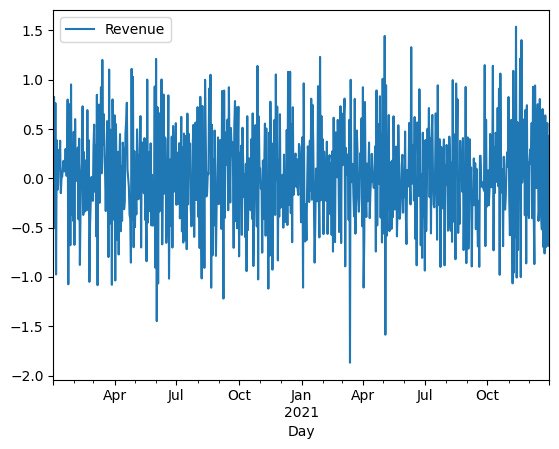

In [28]:
df_diff = df.diff().dropna()

result = adfuller(df_diff)

print('ADF TEST RESULTS')
print(f'\tADF Statistic: {result[0]:0.3f}')
print(f'\tADF p-value: {result[1]:0.3f}')

df_diff.plot()

With a p-value <= 0.05, a single differencing was sufficient to make the data stationary. The plot of the differenced data seems to exhibit a random walk around a mean of 0.0, further confirming that stationarity has been achieved.

#### Split Data into Train and Test Sets

In [29]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False, random_state=5470)
print(df_train.head(3))
print(df_train.tail(3))
print(df_test.head(3))
print(df_test.tail(3))

df_train.to_csv('telco_time_series_train.csv', index=True)
df_test.to_csv('telco_time_series_test.csv', index=True)

y_train = df_train['Revenue'].values
y_test = df_test['Revenue'].values

             Revenue
Day                 
2020-01-01  0.000000
2020-01-02  0.000793
2020-01-03  0.825542
              Revenue
Day                  
2021-08-04  13.520478
2021-08-05  13.082643
2021-08-06  13.504886
              Revenue
Day                  
2021-08-07  13.684826
2021-08-08  13.152903
2021-08-09  13.310290
              Revenue
Day                  
2021-12-29  16.803638
2021-12-30  16.194813
2021-12-31  16.620798


# Part IV: Model Identification and Analysis
---

## D1: Annotated Findings and Visualizations

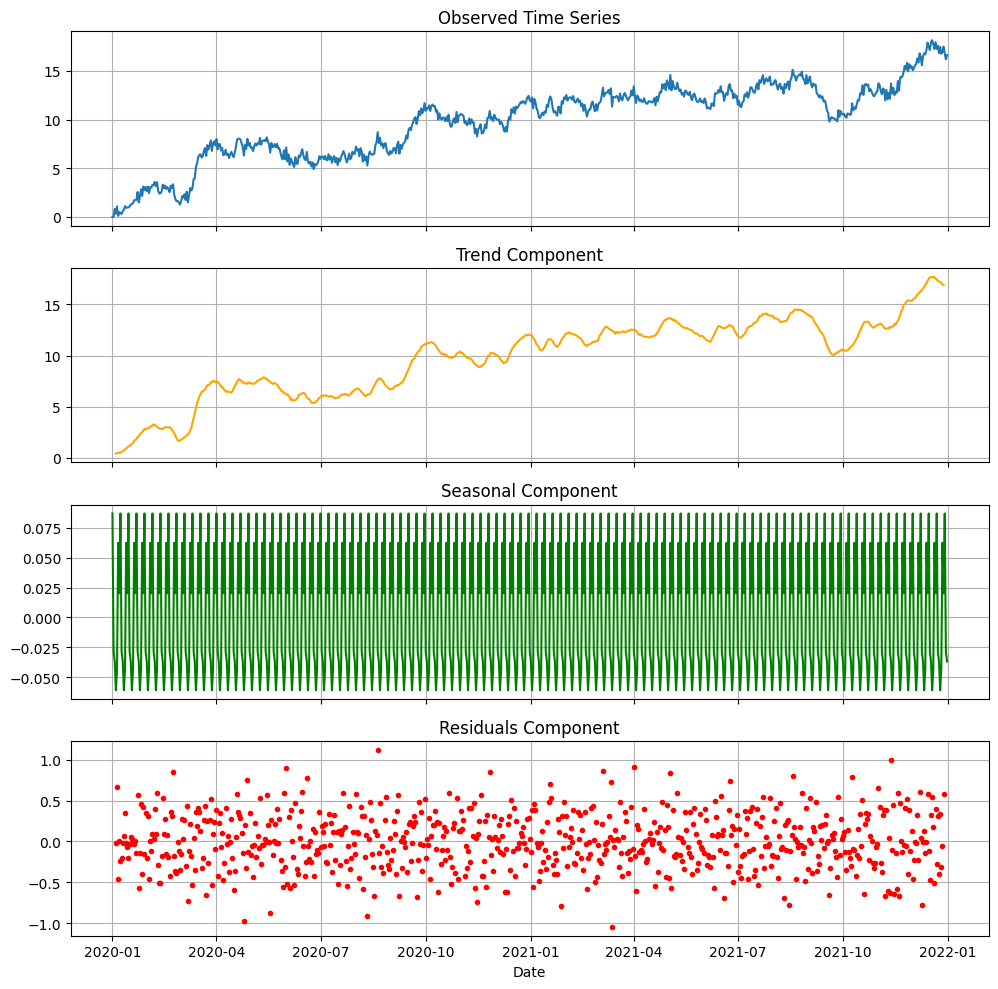

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, model='additive')

fig, axes = plt.subplots(4, 1, figsize=(10,10), sharex=True)
# Plot the observed component
axes[0].plot(result.observed, label='Revenue (Diffed)')
axes[0].set_title("Observed Time Series")
axes[0].grid(True)
axes[0].tick_params(axis='y')
# Plot the trend component
axes[1].plot(result.trend, label='Trend', color='orange')
axes[1].set_title("Trend Component")
axes[1].grid(True)
axes[1].tick_params(axis='y')
# Plot the seasonal component
axes[2].plot(result.seasonal, label='Seasonal', color='green')
axes[2].set_title("Seasonal Component")
axes[2].grid(True)
axes[2].tick_params(axis='y')
# Plot the residual component
axes[3].plot(result.resid, label='Residuals', color='red', marker='.', linestyle='None')
axes[3].set_title("Residuals Component")
axes[3].grid(True)
axes[3].tick_params(axis='y')
axes[3].set_xlabel("Date")

plt.tight_layout()  
plt.show()

In [31]:
# Use ADF to confirm that no trend is present in the residuals
adf_result = adfuller(result.resid.dropna())
print('ADF TEST RESULTS')
print(f'\tADF Statistic: {adf_result[0]:0.3f}')
print(f'\tADF p-value: {adf_result[1]:0.3f}')

ADF TEST RESULTS
	ADF Statistic: -11.553
	ADF p-value: 0.000


#### Seasonality

After decomposing the data, the seasonality graph shows a consistent and repeating pattern. However, the magnitude (y-values) of the seasonality is quite low being well under the magnitude of either the trend or residuals compoents. Nevertheless, it would be helpful to understand the nature of the pattern of seasonality. To do so, we will zoom in on a smaller portion of the data.

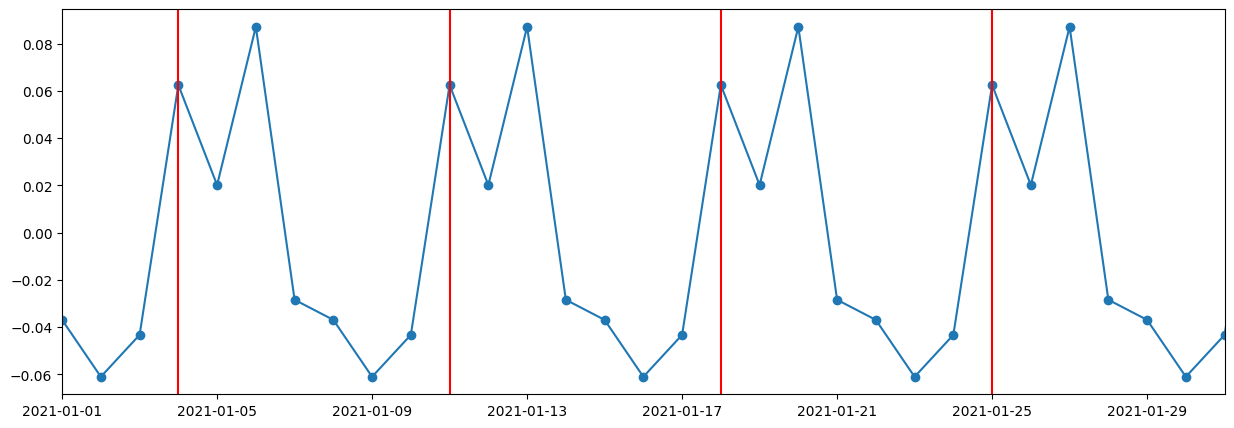

In [32]:
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-01-31')

# Plot seasonal component of the data
plt.figure(figsize = [15,5])
plt.plot(result.seasonal, marker='o')
# Limit to one month
plt.xlim(start_date, end_date)
# Draw red lines on Mondays
for date, _ in result.seasonal.items(): 
    if start_date <= date <= end_date and date.dayofweek == 0:
        plt.axvline(x=date, color='red')
plt.show()

At this scale, it is evident that BigTel's revenue peaks each Wednesday and bottoms out each Saturday.

#### Trends

No obvious trending is present in the differenced dataset. It should be noted that there could be an outlier occurring at the start of the pandemic (March 2020). However, it is of relatively low magnitude so we will leave it as-is.

#### Residuals

ADF was performed on the residuals components. With a p-value very close to zero, there are no trends present in the residuals.

#### Auto-correlation Functions

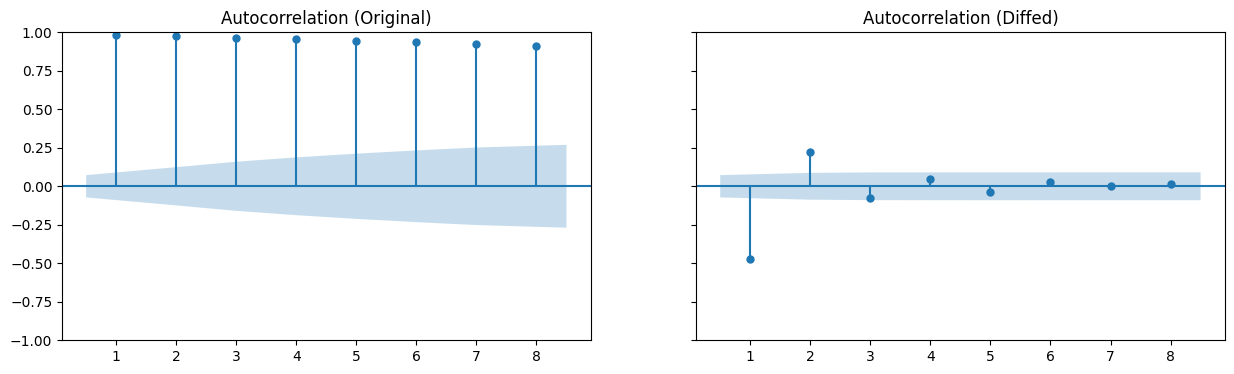

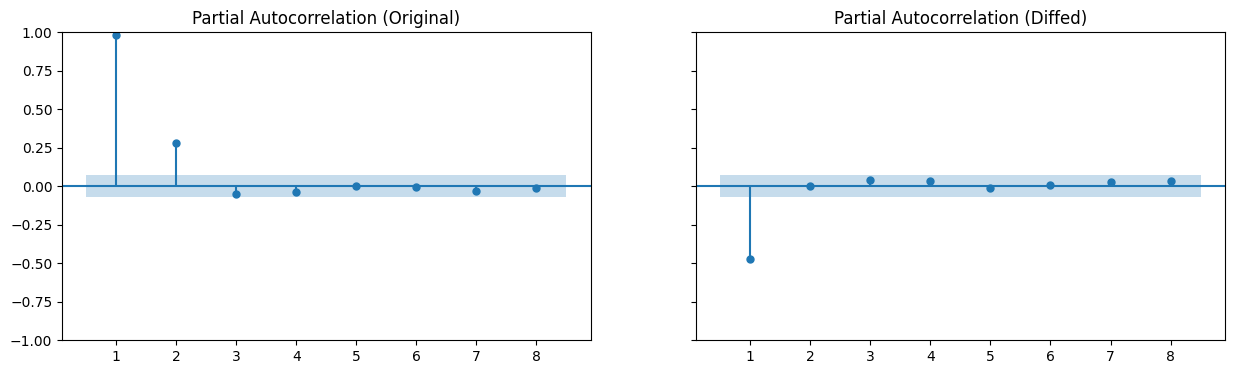

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot original and diffed ACF side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,4], sharey=True)
plot_acf(df, lags=8, zero=False, ax=ax1)
ax1.title.set_text('Autocorrelation (Original)')
plot_acf(df_diff, lags=8, zero=False, ax=ax2)
ax2.title.set_text('Autocorrelation (Diffed)')
plt.show()

# Plot original and diffed PACF side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,4], sharey=True)
plot_pacf(df, lags=8, zero=False, ax=ax1)
ax1.title.set_text('Partial Autocorrelation (Original)')
plot_pacf(df_diff, lags=8, zero=False, ax=ax2)
ax2.title.set_text('Partial Autocorrelation (Diffed)')
plt.show()


The autocorrelation function (ACF) and partial autocorrelation function (PACF) graphs above further demonstrate that the diffed data has achieved stationarity. Further, the graphs suggest that ideal lag values for the autoregressive component of the ARMIA model is 1 (taken from the PACF) and the ideal lag for the moving average component is 2 (taken from the ACF).

#### Spectral Density

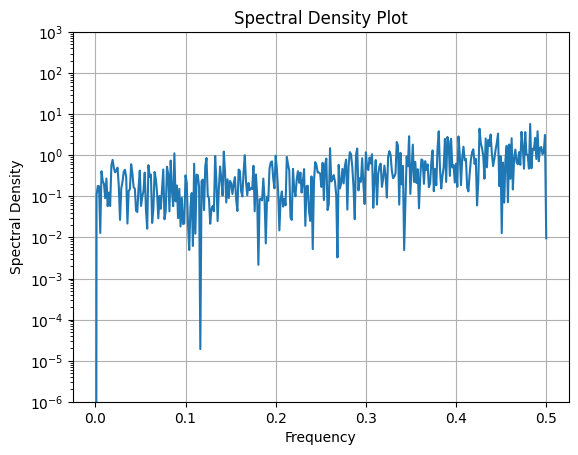

In [34]:
from scipy.signal import periodogram

# Calculate and plot the spectral density (Jake, 2022)
frequencies, spectral_density = periodogram(df_diff['Revenue'])
plt.semilogy(frequencies, spectral_density)
plt.ylim([1e-6, 1e3])
plt.title("Spectral Density Plot")
plt.xlabel("Frequency")
plt.ylabel("Spectral Density")
plt.grid(True)
plt.show()

The spectral density plot shows no obvious patterns in the differenced data.

## D2: Build an Optimal ARIMA Model

In [35]:
# First, use auto_arima to get a starting point
from pmdarima import auto_arima, arima

autogenerated_arima = auto_arima(y_train, d=1, stepwise=True, seasonal=False, suppress_warnings=True, error_action='ignore', max_order=10, trace=True, random_state=5470)
print(autogenerated_arima.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=776.988, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=910.148, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=773.046, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=798.905, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=909.276, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=775.043, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=775.043, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=776.811, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=774.035, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.654 seconds
(1, 1, 0)


We note that the Auto ARIMA chose different degrees than we may have selected from the results of the ACF and PACF.

In [36]:
# Next, create a manual ARIMA using the autogenerated degrees
order=autogenerated_arima.order
#order=(1,1,2)

arima_model_1 = arima.ARIMA(order=order, suppress_warnings=True)
arima_fit_1 = arima_model_1.fit(df_train)

print(f'AIC from auto parameters = {arima_fit_1.aic()}')

order=(1,1,2)

arima_model_2 = arima.ARIMA(order=order, suppress_warnings=True)
arima_fit_2 = arima_model_2.fit(df_train)

print(f'AIC from manual parameters = {arima_fit_2.aic()}')

AIC from auto parameters = 773.0463427966966
AIC from manual parameters = 775.2996865404014


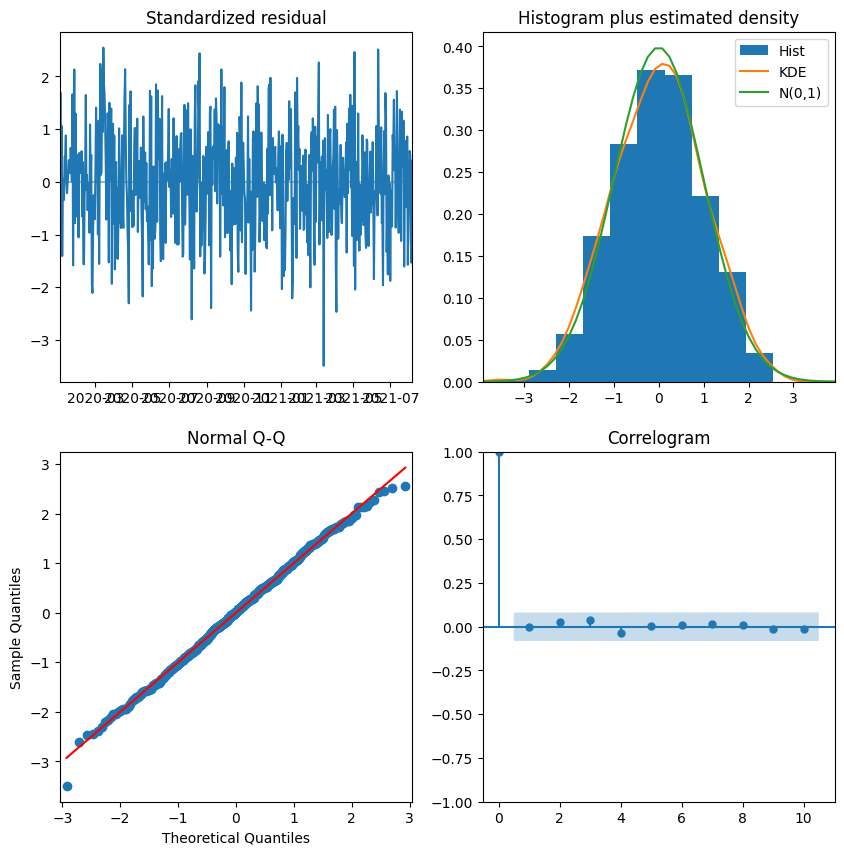

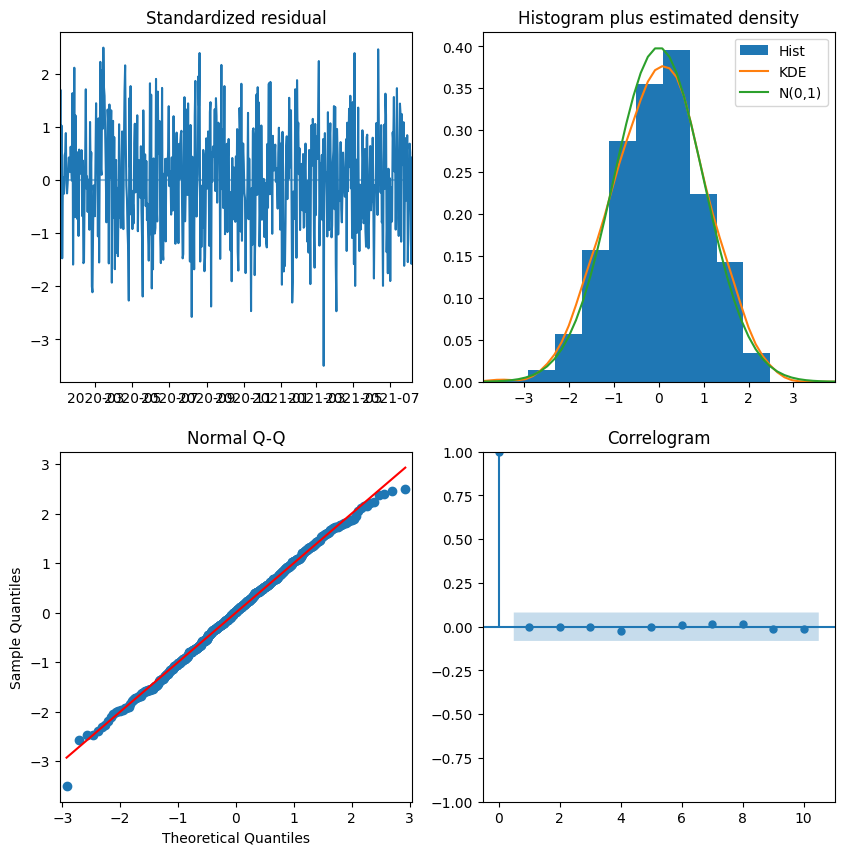

In [37]:
# Plot model diagnostics
arima_fit_1.plot_diagnostics(figsize=[10,10])
plt.show()
arima_fit_2.plot_diagnostics(figsize=[10,10])
plt.show()

## D3: Generate a forecast for the last half of 2021

In [38]:
# Forecast values and confidence intervals using each model
predictions_1, cis_1 = arima_fit_1.predict(n_periods=(df_test.size + 60 ), return_conf_int=True)
test_predictions_1 = predictions_1.iloc[:df_test.size]
future_predictions_1 = predictions_1.iloc[df_test.size:]

predictions_2, cis_2 = arima_fit_2.predict(n_periods=(df_test.size + 60 ), return_conf_int=True)
test_predictions_2 = predictions_2.iloc[:df_test.size]
future_predictions_2 = predictions_2.iloc[df_test.size:]

print(df_train.size, len(test_predictions_2),len(future_predictions_2))

584 147 60


## D4 and D5: Output and Calculations, including code

In [39]:
# Evaluate the model metrics
def model_metrics(model, predictions, actuals):
    mse = ((predictions - actuals) ** 2).mean()
    rmse = (mse ** 0.5)
    mape = np.mean(np.abs((actuals - predictions) / actuals))

    print(f'FORECAST METRICS FOR MODEL {model.upper()}:')
    print(f'\tMSE: {mse:0.3f} (in $M squared)')
    print(f'\tRMSE: {rmse:0.3f} (in $M)')
    print(f"\tMAPE: {mape:0.2%}\n")

model_metrics('Auto ARIMA', test_predictions_1, y_test)
model_metrics('Manual ARIMA', test_predictions_2, y_test)

FORECAST METRICS FOR MODEL AUTO ARIMA:
	MSE: 5.266 (in $M squared)
	RMSE: 2.295 (in $M)
	MAPE: 15.11%

FORECAST METRICS FOR MODEL MANUAL ARIMA:
	MSE: 5.165 (in $M squared)
	RMSE: 2.273 (in $M)
	MAPE: 14.97%



These metrics demonstrate a curious result. Even though the AIC and BIC of the ARIMA using the parameters suggested by Auto ARIMA are slightly lower (better) than those of the ARIMA using our manually determined parameters, it does not deliver the best predictions. The ARIMA using our manually determined parameters yields slightly better MSE, RMSE, and MAPE. The difference is small but our goal is to develop the model which performs best regardless of other synthetic metrics. Therefore, for the remainder of the study, the second model will be used.

# Part V: Data Summary and Implications
---

## E1: Results Discussion

We opted to use an Autoregressive Integrated Moving Average (ARIMA) model for this study. ARIMA is a widely used technique for forecasting time-series data. So, it was a perfect fit for the desired outcomes and objectives of this study. The 'AR' component is a regression between a value and a previous value. The 'MA' component makes predictions based on each observation's residual error. The 'I' component transforms the data through differencing to make it stationary. Stationarity is a must-have characteristic of data for the AR and MA components to work correctly. (Zaina Saadeddin, 2024)

In our analysis, we elected to forecast 207 values on a model trained with 584 observations. This may be an excessive forecast horizon. It may have been better to start with 3 years of data rather than two, or to forecast fewer days. One feature of ARIMA is that the prediction interval increases the farther out in time we forecast. In other words, the range in which we can have a 95% confidence of a correct forecast gets wider each interval forward in time we forecast. The visualization below shows this widening band of prediction interval in gray shading. By the end of the forecast period, the confidence interval is almost as wide as the entire range of observed data. This suggests that our forecast horizon should be signficantly curtailed to perhaps 2-4 weeks. (Hyndman & Athanasopoulos, 2018)

Despite this, the metrics for our ARIMA model look fairly promising. We have a Root Mean Squared Error (RMSE) of $2.3M. This means that the average error between our model's predictions and the corresponding observation from the test dataset was $2.3M. In addition, our model returned a Mean Absolute Percentage Error (MAPE) of 14.97% This is a measure of the percentage the average error represents. In our case, the model's predictions are on average 14.97% different than the actual observations. It is likely that the magnitude of these error metrics is caused by the large downward spike in the test dataset occurring around October 2021. This spike is uncharateristic of the broader revenue trend. Nevertheless, our forecasted values end up very close to the actual values at the end of the test period.

## E2: Forecast Visualization

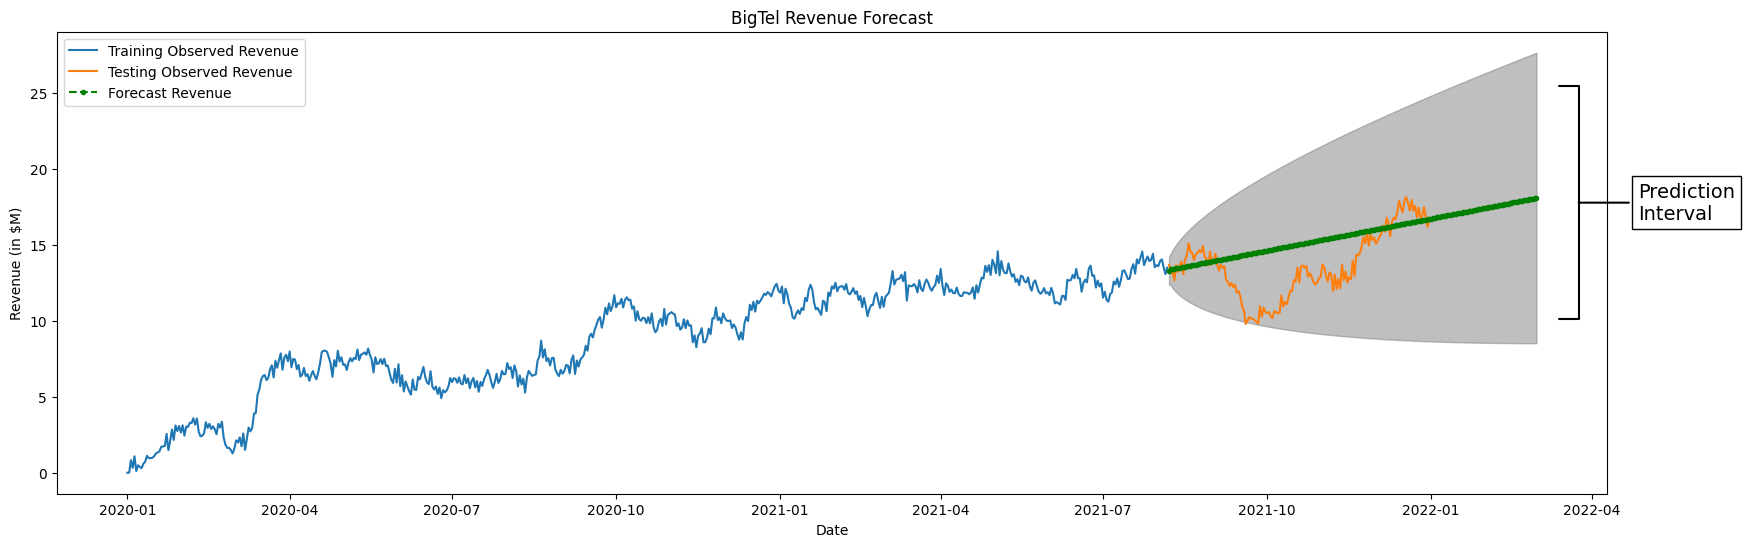

In [40]:
# --------------------- Actual vs. Predicted --------------------------
prediction_dates = pd.date_range(start='08/07/2021', end='03/01/2022')

plt.figure(figsize=(20, 6))
plt.plot(df_train, label='Training Observed Revenue')
plt.plot(df_test.index, y_test, label='Testing Observed Revenue')
plt.plot(prediction_dates, predictions_2.values, color='green', marker='o', markersize=3, linestyle='--', label='Forecast Revenue')

conf_int = np.asarray(cis_2)
plt.fill_between(prediction_dates,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.5, color='gray')

plt.title('BigTel Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue (in $M)')

plt.annotate('Prediction\nInterval', xy=(0.98, 0.63), xytext=(1.02, 0.63), xycoords='axes fraction',
            fontsize=14,
            bbox=dict(boxstyle='square', fc='white', ec='black'), va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=1', lw=1.5, color='black'))

plt.legend(loc='upper left')
plt.show()

Our model's predictions stayed very close to the actual trend line shown in the initial examination of the dataset. (See chart in "Plot the Data" above.) However, the shape of the line does not follow well the variations we observe in the training or test data sets. As mentioned previously, the model did particularly poorly predicting the downward spike in reveune which occurred around October 2021.

## E3: Recommendations

The model exhibits a good understanding of the general trend our revenue numbers follow. Unfortunately, it does not follow the daily ups and downs of revenue with any precision. Therefore, this model is best used for predicting trends rather than specific numbers. Several additional actions may be taken which could improve the predictive power of the model. First, a larger set of training data could be used. Second, the model could be enhanced to address the minor effects of seasonality seen in the repeating pattern of revenue data through the week. It is also important to remember that a time-series model is at it's most accurate on the day it is created. Therefore, processes must be put in place to refresh the model regularly with the latest revenue data. This will ensure that future runs benefit from the most accurate forecasts possible.

# Part VI: Reporting
---

## F: Industry Relevant Development Enviroment

This document was produced entirely within a Jupyter Notebook and exported as a PDF.

## G: Third-Party Code Sources

Chugani, V. (2024, August 13). How to Perform Date and Time Calculations with Pandas. Statology. https://www.statology.org/how-to-perform-date-and-time-calculations-with-pandas/

Jake. (2022, June 20). 3 Ways of Calculating Power Spectral Density in Python. Scicoding; Scicoding. https://www.scicoding.com/calculating-power-spectral-density-in-python/

Zach. (2020, August 13). How to Create a Scatterplot with a Regression Line in Python. Statology. https://www.statology.org/scatterplot-with-regression-line-python/

## H: Works Cited
Data Overload. (2023, June 17). Understanding ARIMA Models: A Comprehensive Guide to Time Series Forecasting. Medium. https://medium.com/@data-overload/understanding-arima-models-a-comprehensive-guide-to-time-series-forecasting-dfc7207f2406

Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: Principles and Practice. Otexts.com. https://otexts.com/fpp2/

Shukla, P. (2023, October 1). ​​Ultimate Guide for ARIMA Time Series Forecasting - Dataaspirant. Dataaspirant. https://dataaspirant.com/arima-time-series-forecasting/

Zaina Saadeddin. (2024, September 9). ARIMA for Time Series Forecasting: A Complete Guide. Datacamp.com; DataCamp. https://www.datacamp.com/tutorial/arima